# Aplicação de técnicas de NLP e Aprendizado de máquina para realizar o reconhecimento de entidades por modelagem de tópicos

In [3]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import regex as re
import string
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans

## 1. Importando dados da preparação e stopwords

In [4]:
PARQUET_MPO_PREPARADOS = '../../Data/Processed/mpo_preparados.parquet'

df_mpo = pd.read_parquet(PARQUET_MPO_PREPARADOS)

In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_mpo.head(5)

,ID,Level,MpoIdentificador,MpoAreaEletrica,MpoCentro,MpoLigadoDesligado,Texto,Título
0,161279,1,IO-PM.6MD,6MD,CNOS,Não definido,Estabelecer os procedimentos a serem seguido...,OBJETIVO
1,161280,2,IO-PM.6MD,6MD,CNOS,Não definido,2.1. Os procedimentos contidos ne...,CONSIDERAÇÕES GERAIS
2,161281,3,IO-PM.6MD,6MD,CNOS,Não definido,1. OBJETIVO 2. ............................,PREPARAÇÃO PARA MANOBRAS EM LINHAS DE TRANSMISSÃO
3,161282,3.1,IO-PM.6MD,6MD,CNOS,Não definido,1. OBJETIVO 2. ............................,LT 230 kV Coletora Porto Velho / Porto Velho C...
4,161283,3.1.1,IO-PM.6MD,6MD,CNOS,Desligar,3.1.1.1. Desenergização da LT 230 ...,Desenergização da LT 230 kV Coletora Porto Vel...


## 2. Vetorizando com tf-idf

In [7]:
# Vetorizando com stopword em português, com limitação de % mínimo e máximo de palavras utilizando monogramas. Palavras que aparecem em menos de 3 documentos ou em mais de 90% deles não são de interesse.
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords, min_df = 3, max_df = 0.90) 

# Utilizando somente fragmentos com ações para energizar ou desenergizar equipamentos. 
X = vectorizer_tfidf.fit_transform(df_mpo[(df_mpo['MpoLigadoDesligado']=='Desligar') | (df_mpo['MpoLigadoDesligado']=='Ligar')]['Texto'])

X

<3491x2892 sparse matrix of type '<class 'numpy.float64'>'
	with 149065 stored elements in Compressed Sparse Row format>

### Inicialmente foi realizada a vetorização com tf-idf sem limitar a quantidade mínima e máximas de ocorrências de palavras em documentos. Isso gerou uma quantidade muito grande de palavras sem significado, tornando a matriz de palavras x documentos grande o suficiente para tornar o seu processamento inviável com técnicas de classificação e agrupamento na máquina host. Dessa forma foram executadas algumas vetorizações variando esses parâmetros e os resultados podem ser observados na tabela abaixo.abs

| Execução | min_df | max_df | Matriz Resultante | Qtd. Elementos |
| ---:| ---: | ---: | :---: | :---: |
| 1a |-|-|5456x8001|306816|
| 2a |0.01|0.99|5456x921|263489|
| 3a |0.05|0.95|5456x508|170520|
| 4a* |3|0.90|3491x2892|149065| 

\* Restrição de fragmentos de energização e desenergização, nos outros casos todos os fragmentos foram utilizados.

### 2.1 Verificando o vocabulário da tokenização

In [8]:
vocab = np.array(vectorizer_tfidf.get_feature_names())
vocab[1700:1800]

array(['ligada', 'ligadas', 'ligado', 'ligados', 'ligar', 'light', 'lima',
       'limitada', 'limitado', 'limitar', 'limitação', 'limitações',
       'limite', 'limites', 'limoeiro', 'lindas', 'linha', 'linhares',
       'linhas', 'link', 'listadas', 'listados', 'litoral', 'lmte', 'lna',
       'lnd', 'lnt', 'lo', 'localizadas', 'logo', 'lon', 'londrina',
       'lopes', 'lt', 'lt1', 'ltbjgd6', 'ltc', 'ltcs', 'ltmc', 'lts',
       'ltte', 'lttf6', 'lucas', 'luis', 'luiz', 'lumenau', 'lumitrans',
       'luxo', 'luzia', 'luziânia', 'luís', 'lxte', 'lógica', 'lógicas',
       'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'ma',
       'macapá', 'macaé', 'macaúbas', 'maceió', 'machadinho', 'machado',
       'madeira', 'magé', 'maior', 'manaus', 'mangabeira', 'manobra',
       'manobrada', 'manobrado', 'manobras', 'manobrável', 'manso',
       'mantendo', 'manter', 'mantido', 'mantê', 'manual', 'manualmente',
       'manutenção', 'marabá', 'maracá', 'maranhão', 'marcador',
       '

### Como o interesse é o de identificar entidades, técnicas como a de lemetização não são interessantes, pois poderiam diminuir a quantidade de informações de interesse. Podemos identificar também que muitas palavras poderiam ainda ser eliminadas como stopwords e este processo poderia se repetir por muitas vezes. A título de exercício vamos continuar o processamento com todas as palavras vetorizadas.

## 3. Modelagem de tópicos com NMF

Fatoração de matriz não negativa (NMF) é uma técnica não supervisionada, logo, não há rotulagem de tópicos nos quais o modelo será treinado. O NMF decompõe vetores de dimensões elevadas em uma representação de dimensões inferiores. Esses vetores de dimensão inferior são não negativos, o que também significa que seus coeficientes não são negativos.

Usando a matriz original (X), o NMF fornecerá duas matrizes (W e H), onde:
 * W são os tópicos encontrados 
 * H são os coeficientes (pesos) para esses tópicos. 

Em outras palavras: X são documentos por palavras (original), H são documentos por tópicos e W são tópicos por palavras.

Para o nosso caso, assumindo 3491 documentos, 2892 palavras e 30 tópicos, obteríamos as seguintes 3 matrizes:

X = tfidf_vectorizer.transform(textos dos documentos)<br>
W = nmf.components_<br>
H = nmf.transform(X)<br>
X = 3491 x 2892<br>
W = 3491 x 30<br>
H = 30 x 2892<br>

O NMF modificará os valores iniciais de W e H para que o produto se aproxime de A até que o erro de aproximação convirja ou as iterações máximas sejam alcançadas.

Em nosso caso, os vetores de alta dimensão serão pesos tf-idf, mas podem ser qualquer coisa, incluindo vetores de palavras ou uma simples contagem bruta de palavras.

### 3.1 Uso de NMF para 10 tópicos, 6 palavras por tópico

In [9]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [10]:
# Quantidade de palavras nos tópicos
num_top_words=6

model_nmf = NMF(n_components=10, max_iter=350, init='nndsvd')

W = model_nmf.fit_transform(X)

H = model_nmf.components_

print(show_topics(H))

['ne 69 mva t2 t1 chesf', 'tf 13 transformador lado 138 230', 'energização sentido operador autonomia especificadas situações', 'banco tr transformador correspondente at bt', 'nco eletronorte 230 terminal 01 porto', 'copel atf get 230 disjuntor abrir', 'ii ne iniciando c1 lt chesf', 'autotransformador lado 138 cemig 345 específica', 'eletrosul 525 lt londrina itá campos', 'lt 500 345 furnas uhe tensão']


### 3.2 Visulização de tópicos com NMF e LDA [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) por Olivier Grisel <olivier.grisel@ensta.org>, Lars Buitinck e Chyi-Kwei Yau <chyikwei.yau@gmail.com>

3491 Documentos, 2892 palavras, 10 tópicos e 20 top palavras

Extracting tf-idf features for NMF...
done in 0.298s.
Extracting tf features for LDA...
done in 0.337s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3491 and n_features=2892...
done in 0.497s.


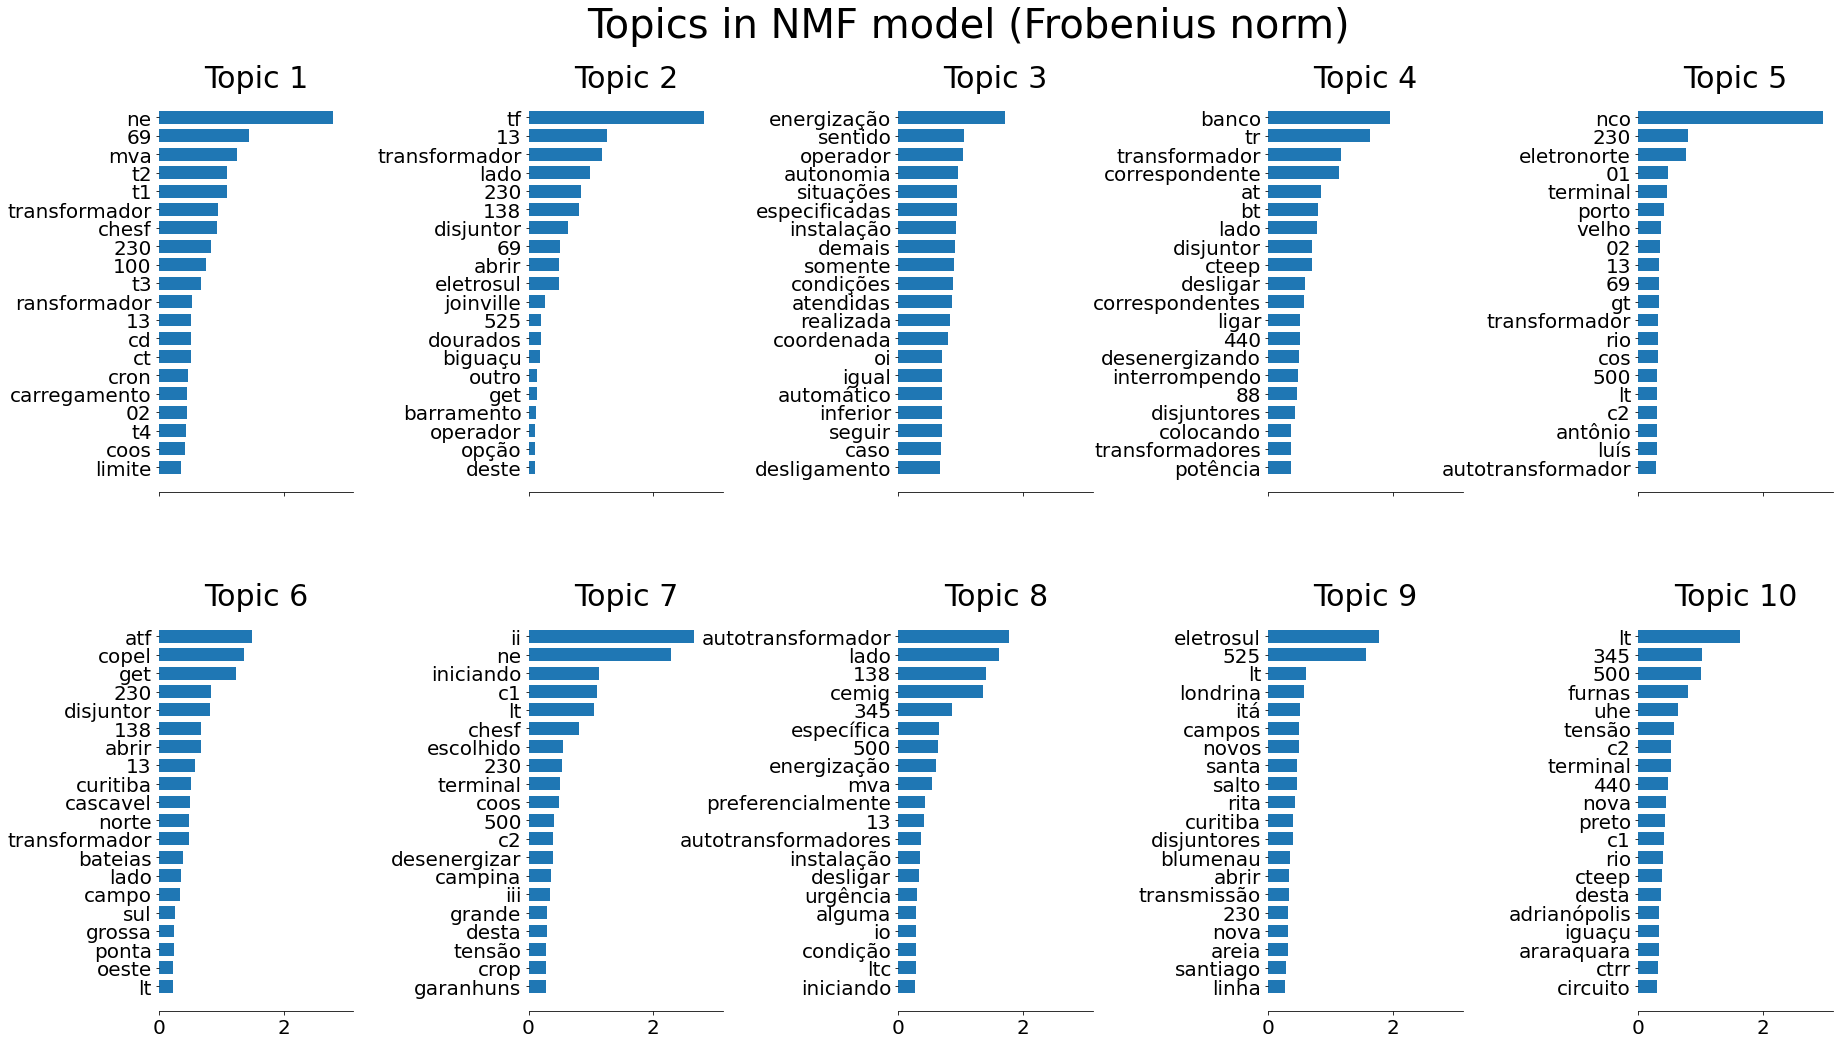



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=3491 and n_features=2892...
done in 5.617s.


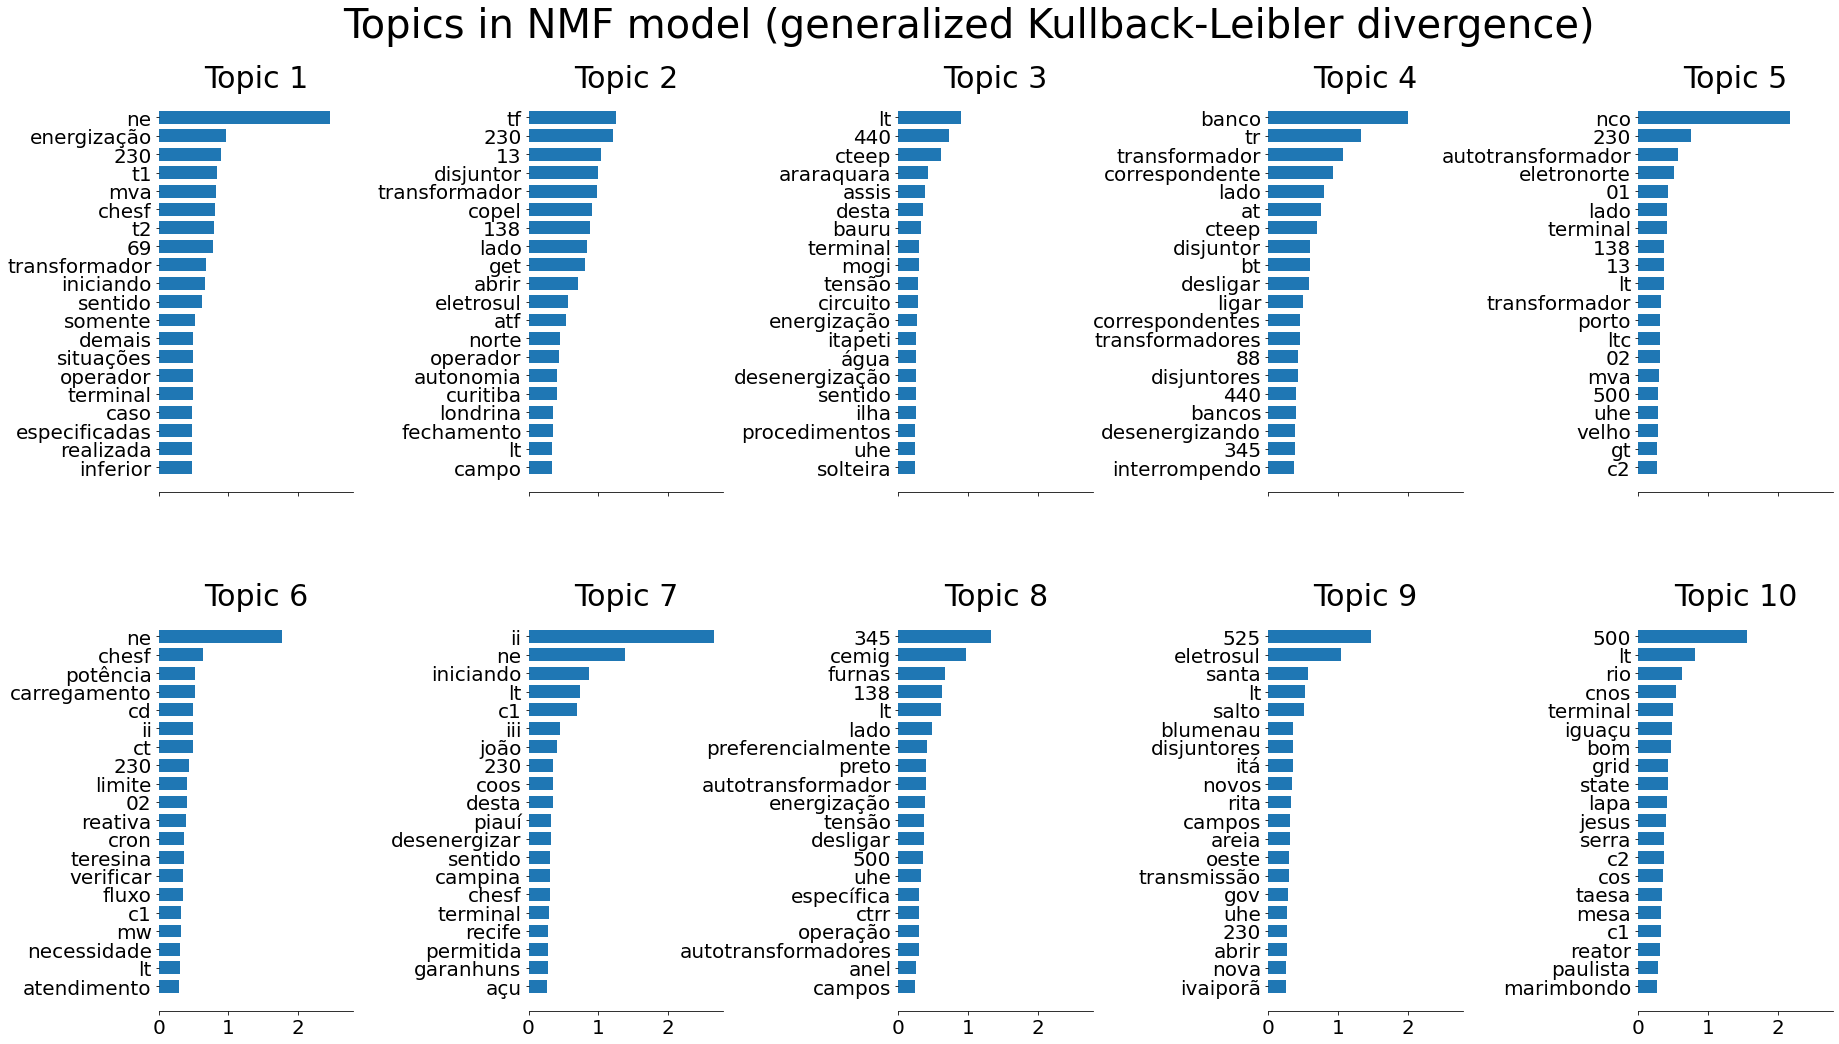



 Fitting LDA models with tf features, n_samples=3491 and n_features=2892...
done in 3.638s.


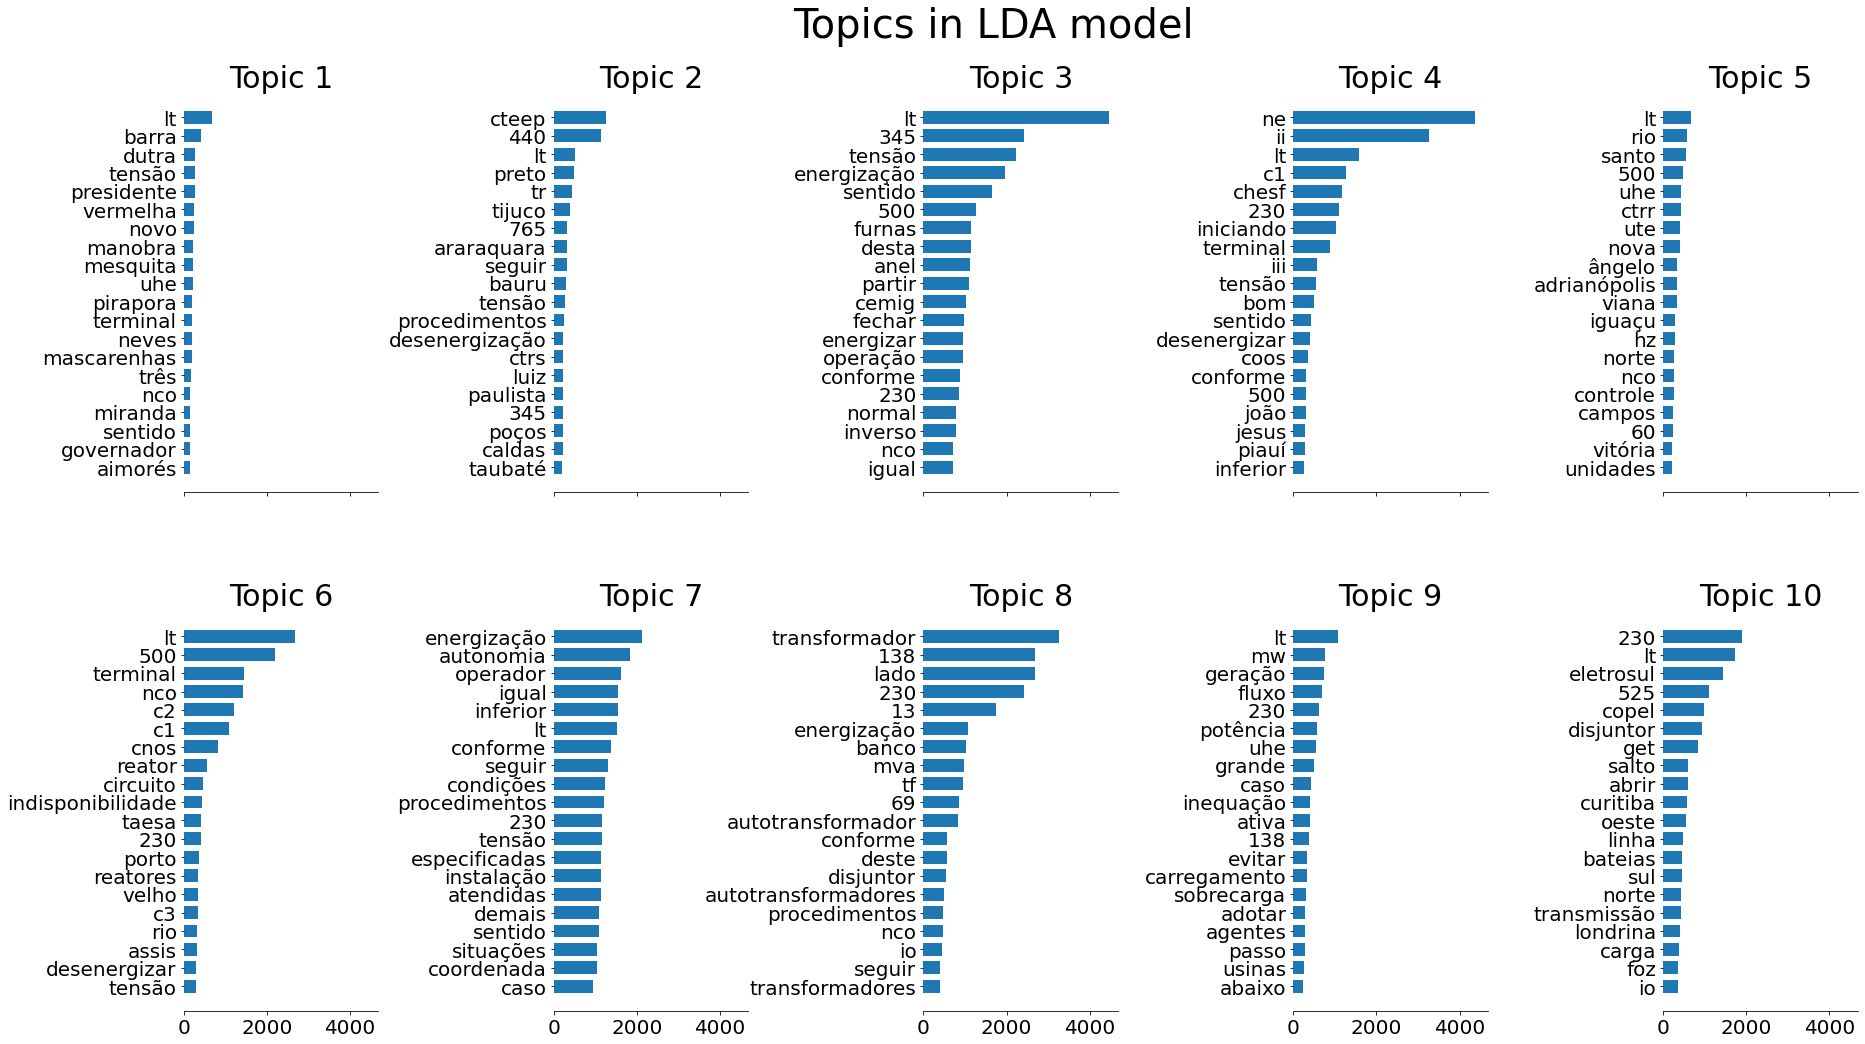

In [11]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 3491
n_features = 2892
n_components = 10
n_top_words = 20

# Adaptação do data_sample
data_samples = (df_mpo[(df_mpo['MpoLigadoDesligado']=='Desligar') | (df_mpo['MpoLigadoDesligado']=='Ligar')]['Texto'])

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3,
                                     max_features=n_features,
                                     stop_words=stopwords)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=3,
                                # max_features=n_features,
                                stop_words=stopwords)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5, init = 'nndsvda').fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

## 4. Clusterização por KNN 

In [12]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=10, verbose=True)

km.fit_transform(X)

print(show_topics(km.cluster_centers_))

Initialization complete
Iteration 0, inertia 5438.851259824928
Iteration 1, inertia 3062.0682814662446
Iteration 2, inertia 3003.6016453476996
Iteration 3, inertia 2977.681303383908
Iteration 4, inertia 2967.38473114255
Iteration 5, inertia 2959.5381058980624
Iteration 6, inertia 2952.7413337513285
Iteration 7, inertia 2948.575533695944
Iteration 8, inertia 2946.284051743195
Iteration 9, inertia 2945.240839403842
Iteration 10, inertia 2944.61595283827
Iteration 11, inertia 2944.0035447914197
Iteration 12, inertia 2943.572158347568
Iteration 13, inertia 2943.1381945589023
Iteration 14, inertia 2942.3998466375097
Iteration 15, inertia 2941.6095019273516
Iteration 16, inertia 2940.869754066905
Iteration 17, inertia 2940.4117209118995
Iteration 18, inertia 2940.047682563773
Iteration 19, inertia 2939.7610244011607
Iteration 20, inertia 2939.7019585733547
Iteration 21, inertia 2939.683823753107
Iteration 22, inertia 2939.6727783993792
Iteration 23, inertia 2939.667398347892
Iteration 24, in

### 4.1 Organização dos clusters

In [13]:
from collections import Counter
c = Counter(km.labels_)
c

Counter({1: 556,
         4: 831,
         8: 365,
         0: 205,
         6: 248,
         2: 614,
         7: 197,
         3: 132,
         9: 196,
         5: 147})

## 5. Conclusão

### Levando em conta as palavras apresentadas nos tópicos criados pela técnica de NMF e LDA, cruzadas com os clusters apresentados pela técnica de KNN, podemos chegar a conclusão de que os agrupamentos fazem sentido entre si e que essas mesmas palavras são forte candidatas a entidades nomeadas que podem ser utilizadas em um modelo de classificação. Uma simples contagem de palavras do resultado da interseção pode nos gerar as TOP 'n' entidades.
### Como evolução, a descoberta da quantidade de tópicos 'ideal' poderia de alguma forma ser observada. Talvez utilizar algum tipo de score de coerência como a distância relativa entre palavras num tópico. Mais informações podem ser encontradas [aqui](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)